In [121]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [122]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random

In [123]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [124]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [125]:
tf.keras.backend.clear_session()

In [126]:
subject = 'Acre - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [127]:
data = pd.read_csv('2003_mo_model_input_AC.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Acre - Consumo de Cimento (t),Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,3.260,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,2.191,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,2.154,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,2.643,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,2.546,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


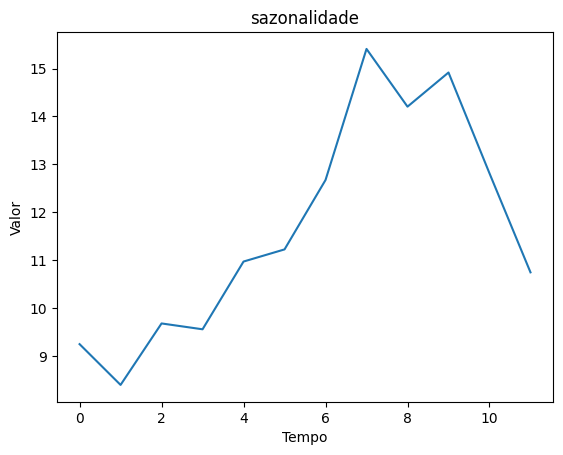

,sazonalidade
sazonalidade,
0,9.247150
1,8.395791
2,9.679136
3,9.557209
4,10.971298
5,11.224848
6,12.673448
7,15.410067
8,14.204934


In [128]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [129]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - IDH,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - PIB - Preços de Mercado,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Acre - Consumo de Cimento (t)
0,2003-1,10254.061200,0.773065,0.651726,8.722906,0.691320,7.285707e+06,413409.255032,9.318417,6.587220e+06,0.643805,247158.775150,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,9.247150,3.260
1,2003-2,10335.111969,0.773454,0.651847,8.718028,0.691617,7.294881e+06,413607.843560,9.319990,6.590338e+06,0.644270,248180.775732,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.395791,2.191
2,2003-3,10411.052710,0.773843,0.651968,8.713149,0.691914,7.304055e+06,413806.432089,9.321563,6.593455e+06,0.644734,249202.776314,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.679136,2.154
3,2003-4,10486.231639,0.774233,0.652088,8.708271,0.692212,7.313229e+06,414005.020618,9.323136,6.596572e+06,0.645199,250224.776896,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.557209,2.643
4,2003-5,10566.989914,0.774622,0.652209,8.703393,0.692509,7.322403e+06,414203.609146,9.324709,6.599689e+06,0.645663,251246.777478,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,10.971298,2.546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,39738.391869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.971298,NaN
245,2023-6,39713.363501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.224848,NaN
246,2023-7,39639.488252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.673448,NaN
247,2023-8,39545.723370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.410067,NaN


In [130]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      5.807
1      5.242
2      4.965
3      5.854
4      5.892
       ...  
244      NaN
245      NaN
246      NaN
247      NaN
248      NaN
Name: Acre - Consumo de Cimento (t), Length: 249, dtype: float64

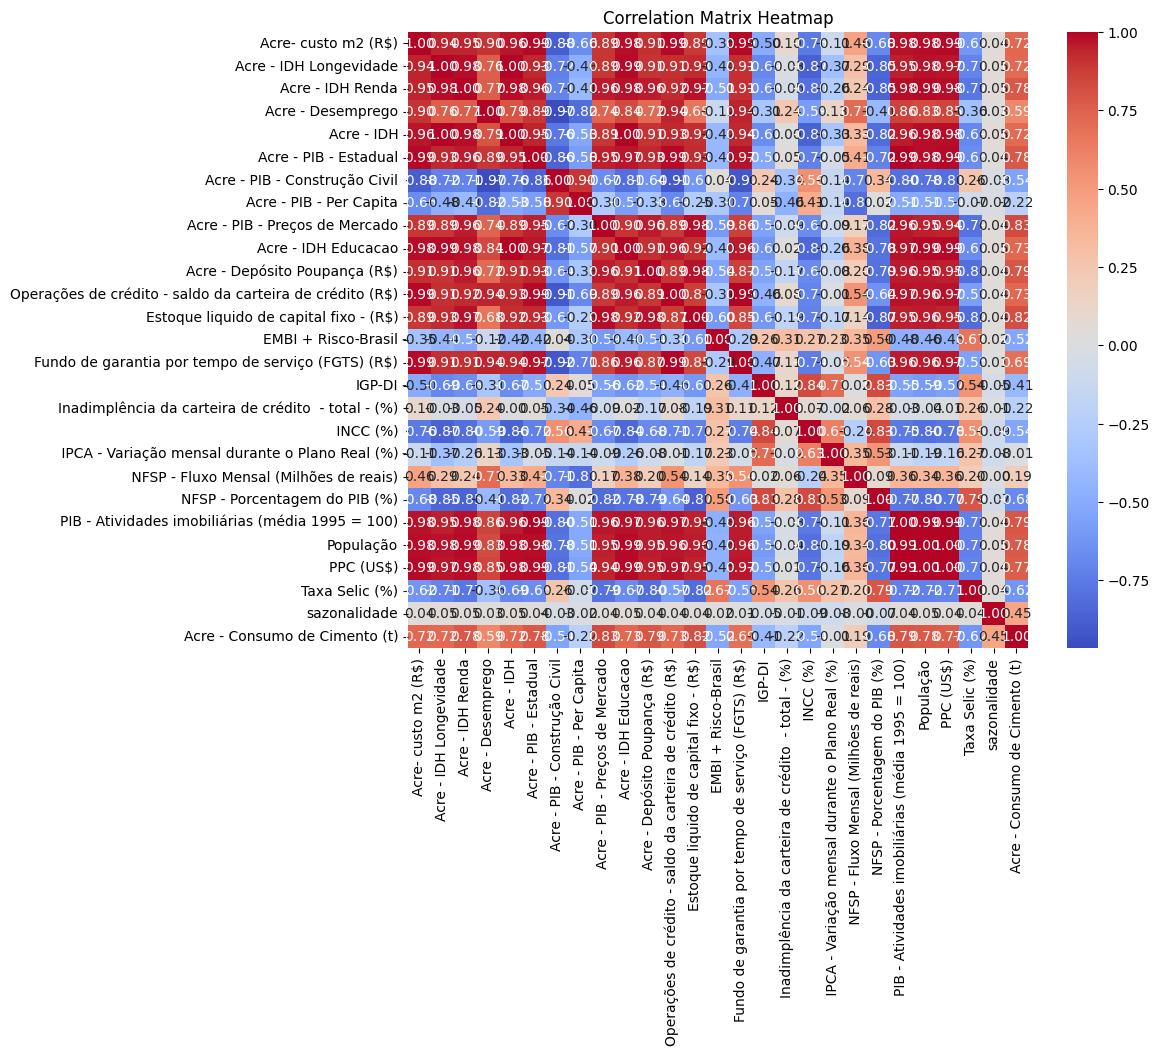

In [131]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [132]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [133]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Acre- custo m2 (R$),2.703098e+04
1,Acre - IDH Longevidade,8.988108e+08
2,Acre - IDH Renda,3.508612e+03
3,Acre - Desemprego,8.021215e+02
4,Acre - IDH,3.142761e+09
5,Acre - PIB - Estadual,2.238871e+05
6,Acre - PIB - Construção Civil,5.970403e+03
7,Acre - PIB - Per Capita,8.953737e+03
8,Acre - PIB - Preços de Mercado,6.645431e+04
9,Acre - IDH Educacao,1.926509e+08


In [134]:
# data =data.drop(['Acre- custo m2 (R$)',
#                  'Acre - IDH Longevidade',
#                  'Acre - IDH Renda', 
#                  'Acre - PIB - Estadual'], axis=1)
data = remove_high_vif_columns(safe_data, 100000000)
data

Num columns removed: 2


,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,10254.061200,0.773065,0.651726,8.722906,7.285707e+06,413409.255032,9.318417,0.643805,247158.775150,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,9.247150
1,10335.111969,0.773454,0.651847,8.718028,7.294881e+06,413607.843560,9.319990,0.644270,248180.775732,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,8.395791
2,10411.052710,0.773843,0.651968,8.713149,7.304055e+06,413806.432089,9.321563,0.644734,249202.776314,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,9.679136
3,10486.231639,0.774233,0.652088,8.708271,7.313229e+06,414005.020618,9.323136,0.645199,250224.776896,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,9.557209
4,10566.989914,0.774622,0.652209,8.703393,7.322403e+06,414203.609146,9.324709,0.645663,251246.777478,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,10.971298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,27302.030024,0.805978,0.662282,12.189263,8.624684e+06,390265.764799,9.232189,0.698981,669197.434991,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,15.410067
176,27410.180766,0.805877,0.662298,12.181187,8.623631e+06,390439.148472,9.231720,0.699182,673940.440969,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,14.204934
177,27516.873824,0.805776,0.662314,12.173112,8.622579e+06,390612.532145,9.231251,0.699383,678683.446948,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,14.917558
178,27623.147818,0.805675,0.662331,12.165036,8.621526e+06,390785.915818,9.230783,0.699585,683426.452926,3.083099e+06,7.776397e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,1.989930e+08,419.430070,1.004174,12.812993


In [135]:
input_data = data
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.496468,-2.305165,-2.252315,-0.743171,-1.704243,0.414350,-0.535913,-1.986576,-1.759857,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.077625
1,-1.481425,-2.261292,-2.213954,-0.746212,-1.684197,0.431295,-0.509562,-1.956583,-1.753366,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.458907
2,-1.467331,-2.217419,-2.175594,-0.749254,-1.664151,0.448239,-0.483210,-1.926589,-1.746875,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.884159
3,-1.453377,-2.173546,-2.137233,-0.752295,-1.644106,0.465183,-0.456859,-1.896596,-1.740383,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.938764
4,-1.438389,-2.129673,-2.098872,-0.755336,-1.624060,0.482128,-0.430507,-1.866603,-1.733892,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.305461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.667644,1.405091,1.098686,1.417873,1.221491,-1.560335,-1.980523,1.576708,0.920796,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,1.682449
176,1.687717,1.393719,1.103897,1.412839,1.219191,-1.545541,-1.988375,1.589708,0.950922,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,1.142728
177,1.707520,1.382347,1.109108,1.407804,1.216891,-1.530748,-1.996227,1.602709,0.981048,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.461879
178,1.727244,1.370975,1.114319,1.402770,1.214591,-1.515954,-2.004079,1.615709,1.011174,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.519345


In [136]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-1.496468,-2.305165,-2.252315,-0.743171,-1.704243,0.414350,-0.535913,-1.986576,-1.759857,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,-1.077625
1,-1.481425,-2.261292,-2.213954,-0.746212,-1.684197,0.431295,-0.509562,-1.956583,-1.753366,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-1.458907
2,-1.467331,-2.217419,-2.175594,-0.749254,-1.664151,0.448239,-0.483210,-1.926589,-1.746875,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,-0.884159
3,-1.453377,-2.173546,-2.137233,-0.752295,-1.644106,0.465183,-0.456859,-1.896596,-1.740383,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.938764
4,-1.438389,-2.129673,-2.098872,-0.755336,-1.624060,0.482128,-0.430507,-1.866603,-1.733892,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.305461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.423364,1.517246,1.192647,1.508258,1.227396,-1.663997,-1.843725,1.500122,0.716911,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,1.682449
164,1.441579,1.510736,1.166559,1.497229,1.229435,-1.663976,-1.860092,1.497239,0.715511,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,1.142728
165,1.461137,1.504226,1.140472,1.486201,1.231474,-1.663955,-1.876459,1.494356,0.714112,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.461879
166,1.481677,1.497715,1.114384,1.475172,1.233513,-1.663934,-1.892826,1.491473,0.712713,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.519345


In [137]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0       5.807
1       5.242
2       4.965
3       5.854
4       5.892
        ...  
163    15.749
164    14.269
165    15.367
166    14.595
167     9.811
Name: Acre - Consumo de Cimento (t), Length: 168, dtype: float64

In [138]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [139]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 24)

In [140]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Acre- custo m2 (R$),Acre - IDH Longevidade,Acre - IDH Renda,Acre - Desemprego,Acre - PIB - Estadual,Acre - PIB - Construção Civil,Acre - PIB - Per Capita,Acre - IDH Educacao,Acre - Depósito Poupança (R$),Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.828515,0.486280,0.769825,1.092239,1.082112,-0.669697,-0.119584,0.664503,1.384998,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,-1.077625
133,0.847574,0.481447,0.750526,1.116799,1.088707,-0.731996,-0.201625,0.667129,1.337476,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-1.458907
134,0.865900,0.476615,0.731226,1.141358,1.095302,-0.794295,-0.283665,0.669755,1.289954,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,-0.884159
135,0.884375,0.471783,0.711927,1.165918,1.101897,-0.856594,-0.365706,0.672381,1.242432,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.938764
136,0.902841,0.466951,0.692627,1.190478,1.108492,-0.918893,-0.447746,0.675008,1.194910,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,-0.305461
137,0.924367,0.462118,0.673328,1.215038,1.115087,-0.981192,-0.529787,0.677634,1.147388,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-0.191909
138,0.947047,0.457286,0.654028,1.239597,1.121682,-1.043491,-0.611827,0.680260,1.099867,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,0.456850
139,0.966662,0.452454,0.634729,1.264157,1.128277,-1.105791,-0.693868,0.682886,1.052345,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,1.682449
140,0.984791,0.447622,0.615429,1.288717,1.134872,-1.168090,-0.775908,0.685512,1.004823,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,1.142728
141,1.003120,0.442789,0.596130,1.313277,1.141467,-1.230389,-0.857949,0.688139,0.957301,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,1.461879


In [141]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 24)

In [142]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [143]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(36, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(108, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.07,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [144]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [145]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[851016629, 3004625137, 2542115166, 3532333997, 759568111, 27459162, 567674765, 3851578510, 3917284016, 2633418357]


Step: 0 ___________________________________________
val_loss: 2.354867458343506
winner_seed: 851016629


Step: 1 ___________________________________________
val_loss: 2.19806170463562
winner_seed: 3004625137


Step: 2 ___________________________________________
val_loss: 2.2795119285583496


Step: 3 ___________________________________________
val_loss: 2.3148231506347656


Step: 4 ___________________________________________
val_loss: 2.1804327964782715
winner_seed: 759568111


Step: 5 ___________________________________________
val_loss: 2.14178466796875
winner_seed: 27459162


Step: 6 ___________________________________________
val_loss: 2.4630260467529297


Step: 7 ___________________________________________
val_loss: 2.382542610168457


Step: 8 ___________________________________________
val_loss: 2.0353851318359375
winner_seed: 3917284016


Step: 9 _________________

In [2]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)
# 3917284016

NameError: name 'lstm_model' is not defined

In [147]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [148]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,10.255057,8.857046,8.96786,10.357189,12.51189,14.669719,15.930025,16.461666,16.066496,15.279581,14.018583,11.66019
Target,11.188,10.381,8.08,11.154,12.508,12.126,14.496,16.723,15.253,16.531,15.206,10.16
Error,0.932942,1.523953,0.88786,0.796811,0.00389,2.543718,1.434025,0.261333,0.813496,1.251419,1.187417,1.50019


In [149]:
display(mae)
display(mape)

1.0947546

0.09091071

In [150]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [151]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 17ms/step
Ano-11: |Prediction[[155.03531]] - Target[153.80599999999998]| =  Error: [[1.2293091]]; MAPE:[[0.0079926]]


[array([[1.2293091]], dtype=float32)]

1.2293091

0.007992595